In [8]:
import numpy as np
from upkit import Histo, Histo2D
import scipy as sp
import pandas as pd
from signal_NN.signal_classifier import SidebandClassifier
from signal_NN.utils import *
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow import keras



In [9]:
def build_region_masks(MM, bin_edges, SB_low=(0.65,0.80), SB_high=(1.15,1.5), SIG=(0.8, 1.05), pi_s=None):
    if SIG is None:
        if pi_s is None:
            raise ValueError("pi_s must be provided when SIG=None")
        signal_bins = np.where(pi_s > 0.01)[0]
        SIG = (bin_edges[signal_bins[0]], bin_edges[signal_bins[-1] + 1])
    
    else:
        SIG = SIG

    sb_mask_low  = (MM >= SB_low[0])  & (MM < SB_low[1])
    sb_mask_high = (MM >= SB_high[0]) & (MM < SB_high[1])
    sideband_mask = sb_mask_low | sb_mask_high

    central_mask = (MM >= SIG[0]) & (MM < SIG[1])

    return sideband_mask, central_mask


def build_classifier(input_dim):
    model = keras.Sequential([
        keras.layers.Input(shape=(input_dim,)),
        keras.layers.Dense(256, activation='relu'),
        keras.layers.Dense(256, activation='relu'),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(32, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(
        optimizer=keras.optimizers.Adam(1e-3),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model


def train_background_classifier(X, MM, pi_s, bin_edges):
    sideband_mask, central_mask = build_region_masks(MM, pi_s=pi_s, bin_edges=bin_edges)

    X_bg  = X[sideband_mask]
    X_mix = X[central_mask]

    y_bg  = np.zeros(len(X_bg), dtype=int)
    y_mix = np.ones(len(X_mix), dtype=int)

    X_cls = np.vstack([X_bg, X_mix])
    y_cls = np.concatenate([y_bg, y_mix])

    X_train, X_val, y_train, y_val = train_test_split(
        X_cls, y_cls, test_size=0.20, random_state=42
    )

    model = build_classifier(input_dim=X.shape[1])
    model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=10,
        batch_size=2048,
        verbose=1
    )

    return model


def predict_scores(model, X, MM, bin_edges, pi_s):
    _, central_mask = build_region_masks(MM, pi_s=pi_s, bin_edges=bin_edges)
    X_central = X[central_mask]
    MM_central = MM[central_mask]

    scores = model.predict(X_central, batch_size=5000, verbose=0).flatten()

    # Determine MM bin for each central event
    bin_id = np.digitize(MM_central, bin_edges) - 1
    return scores, bin_id, central_mask


def compute_ranked_Q(scores, bin_id, pi_s, num_bins):
    """
    Compute continuous Q-factors using the classifier likelihood ratio.

    Q_i = (pi_s(b) * LR_i) / (pi_s(b) * LR_i + (1 - pi_s(b)))

    where LR_i = D_i / (1 - D_i)
    and D_i is the classifier sigmoid score.
    """
    Q = np.zeros_like(scores, dtype=float)

    eps = 1e-9  # numerical stability

    for b in range(num_bins):
        idx = np.where(bin_id == b)[0]
        if len(idx) == 0:
            continue

        p = pi_s[b]

        # classifier score D(x)
        D = np.clip(scores[idx], eps, 1 - eps)

        # likelihood ratio LR = D / (1 - D)
        LR = D / (1.0 - D)

        # Bayesian Q-factor combining LR + per-bin prior pi_s
        Q_bin = (p * LR) / (p * LR + (1.0 - p))

        Q[idx] = Q_bin

    return Q

# def assign_Q_from_sideband_classifier(X, MM, pi_s, bin_edges):
#     model = train_background_classifier(X[:,1:], MM, pi_s=pi_s, bin_edges=bin_edges)
#     scores, bin_id, central_mask = predict_scores(model, X[:,1:], MM, pi_s=pi_s, bin_edges=bin_edges)

#     num_bins = len(bin_edges)-1
#     Q_central = compute_Q_from_scores(scores, bin_id, pi_s, num_bins)
#     # Q_central = compute_ranked_Q(scores, bin_id, pi_s, num_bins)

#     Q_full = np.zeros(len(X))
#     Q_full[central_mask] = Q_central

#     # Give outside region a tiny value instead of exactly zero
#     Q_full[~central_mask] = 0.01 * np.mean(Q_central)

#     return Q_full, model

def assign_Q_from_sideband_classifier(X, MM, y_true, pi_s, bin_edges, T=None):
    # 1) Train classifier on sidebands vs central
    model = train_background_classifier(X[:,1:], MM, pi_s=pi_s, bin_edges=bin_edges)

    # 2) Get central-region scores and bin IDs
    raw_scores, bin_id, central_mask = predict_scores(model, X[:,1:], MM, pi_s=pi_s, bin_edges=bin_edges)

    # 3) Optional: Platt calibration using toy/MC labels
    if y_true is not None:
        platt = PlattScaler()
        y_central = y_true[central_mask]
        platt.fit(raw_scores, y_central)
        scores = platt.predict(raw_scores)
    else:
        scores = raw_scores

    # 4) Soft Q from scores
    num_bins = len(bin_edges) - 1
    Q_central = compute_Q_from_scores(scores, bin_id, pi_s, num_bins, T=T)

    # 5) Fill full array
    Q_full = np.zeros(len(X))
    Q_full[central_mask] = Q_central

    return Q_full, model

# def assign_Q_from_sideband_classifier(X, MM, y_true, pi_s, bin_edges):
#     """
#     X[:,1:] are classifier features (MM excluded)
#     y_true is only used for Platt scaling calibration (toy MC only)
#     """
#     # ------------------------------------------------------
#     # 1. Train classifier
#     # ------------------------------------------------------
#     model = train_background_classifier(X[:,1:], MM, pi_s=pi_s, bin_edges=bin_edges)

#     # ------------------------------------------------------
#     # 2. Identify central region and compute raw scores
#     # ------------------------------------------------------
#     raw_scores, bin_id, central_mask = predict_scores(model, X[:,1:], MM, bin_edges, pi_s)

#     # ------------------------------------------------------
#     # 3. Calibrate (Platt scaling) using toy MC labels
#     #    ONLY use central-region events for calibration—
#     #    since that is where LR will be used.
#     # ------------------------------------------------------
#     platt = PlattScaler()

#     # labels corresponding to events WITHIN the central region
#     y_central = y_true[central_mask]     # (1 = signal, 0 = bkg)

#     platt.fit(raw_scores, y_central)
#     calibrated_scores = platt.predict(raw_scores)

#     # ------------------------------------------------------
#     # 4. Compute Q-factors bin-by-bin using calibrated scores
#     # ------------------------------------------------------
#     num_bins = len(bin_edges) - 1
#     Q_central = compute_ranked_Q(calibrated_scores, bin_id, pi_s, num_bins)

#     # ------------------------------------------------------
#     # 5. Expand back into the full data sample
#     # ------------------------------------------------------
#     Q_full = np.zeros(len(X))
#     Q_full[central_mask] = Q_central

#     # Events outside central region get tiny weight to avoid zeros
#     Q_full[~central_mask] = 0.01 * np.mean(Q_central)

#     return Q_full, model, platt

import numpy as np

def compute_Q_from_scores(scores, bin_id, pi_s, num_bins, eps=1e-9, T=None):
    """
    Continuous Q using classifier scores as shape and π_s as per-bin normalization.

    scores : 1D array of classifier scores in [0,1] (for central-region events)
    bin_id : integer MM-bin indices for those events
    pi_s   : array of per-bin signal fractions, length = num_bins
    T      : optional temperature for softening/sharpening the scores
             (T > 1 softer, T < 1 sharper). T=None means no temperature scaling.
    """
    scores = np.asarray(scores, dtype=float)
    Q = np.zeros_like(scores, dtype=float)

    for b in range(num_bins):
        idx = np.where(bin_id == b)[0]
        if len(idx) == 0:
            continue

        p = pi_s[b]
        if p <= 0:
            # prior says essentially no signal here
            continue

        s = scores[idx].copy()
        # keep away from exact 0/1
        s = np.clip(s, eps, 1.0 - eps)

        # Optional: temperature scaling in score space
        if T is not None:
            z = np.log(s / (1.0 - s))       # logit
            z = z / T
            s = 1.0 / (1.0 + np.exp(-z))    # sigmoid(logit/T)

        mean_s = s.mean()
        if mean_s < eps:
            # classifier thinks everything here is background
            continue

        # scale scores so that <Q>_bin ≈ π_s(b)
        scale = p / mean_s
        q_bin = scale * s

        # enforce 0 <= Q <= 1
        q_bin = np.clip(q_bin, 0.0, 1.0)

        Q[idx] = q_bin

    return Q

def compute_pi_s(MM, y, bin_edges):
    bin_id = np.digitize(MM, bin_edges) - 1
    num_bins = len(bin_edges) - 1

    pi_s = np.zeros(num_bins)
    pi_s_unc = np.zeros(num_bins)

    for b in range(num_bins):
        mask = bin_id == b
        if np.any(mask):
            frac = y[mask].mean()
            pi_s[b] = frac
            pi_s_unc[b] = 0.05 * frac + 1e-3  # toy uncertainty
        else:
            pi_s[b] = 0.0
            pi_s_unc[b] = 1e-3
    return pi_s, pi_s_unc, bin_id

import numpy as np
from sklearn.linear_model import LogisticRegression

class PlattScaler:
    def __init__(self):
        self.model = None

    def fit(self, scores, labels):
        """
        Fit Platt scaling: maps raw classifier score -> calibrated probability.
        """
        scores = np.array(scores).reshape(-1, 1)
        labels = np.array(labels).astype(int)

        # Logistic regression with no regularization (C very large)
        lr = LogisticRegression(C=1e6, solver='lbfgs')
        lr.fit(scores, labels)
        self.model = lr

    def predict(self, scores):
        """
        Apply Platt scaling: returns calibrated probability P(sig | score).
        """
        scores = np.array(scores).reshape(-1, 1)
        return self.model.predict_proba(scores)[:, 1]


In [10]:
if __name__ == "__main__":
    # --- generate toy ---
    X_train, X_test, y_train, y_test = generate_correlated_toy(num_events=200_000_0, signal_fraction=0.1)
    MM = X_train[:,0]

    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)

    # --- binning ---
    bin_edges = np.linspace(0.65, 1.25, 50)
    pi_s, pi_s_unc, bin_id = compute_pi_s(MM, y_train, bin_edges)

    # --- Q assignment ---
    Q, model = assign_Q_from_sideband_classifier(X_train, MM, y_train, pi_s, bin_edges, T = 7)

    # --- diagnostics ---
    print("Total true signal:", y_train.sum())
    print("Total Q yield:", Q.sum())
    print("Yield error:", Q.sum() - y_train.sum())

    # Quick bin check
    for b in range(10):
        m = (bin_id == b)
        print(f"bin {b:3d}  pi_s={pi_s[b]:.3f}   Q_mean={Q[m].mean():.3f}")

Epoch 1/10


2025-11-17 10:55:30.340582: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


288/288 [==============================] - 2s 8ms/step - loss: 0.5264 - accuracy: 0.7581 - val_loss: 0.5107 - val_accuracy: 0.7708
Epoch 2/10
288/288 [==============================] - 2s 8ms/step - loss: 0.5079 - accuracy: 0.7715 - val_loss: 0.5069 - val_accuracy: 0.7724
Epoch 3/10
288/288 [==============================] - 2s 8ms/step - loss: 0.5068 - accuracy: 0.7718 - val_loss: 0.5064 - val_accuracy: 0.7726
Epoch 4/10
288/288 [==============================] - 2s 8ms/step - loss: 0.5066 - accuracy: 0.7718 - val_loss: 0.5055 - val_accuracy: 0.7730
Epoch 5/10
288/288 [==============================] - 2s 8ms/step - loss: 0.5062 - accuracy: 0.7722 - val_loss: 0.5068 - val_accuracy: 0.7719
Epoch 6/10
288/288 [==============================] - 2s 8ms/step - loss: 0.5059 - accuracy: 0.7724 - val_loss: 0.5064 - val_accuracy: 0.7727
Epoch 7/10
288/288 [==============================] - 2s 8ms/step - loss: 0.5059 - accuracy: 0.7723 - val_loss: 0.5055 - val_accuracy: 0.7725
Epoch 8/10
288/28

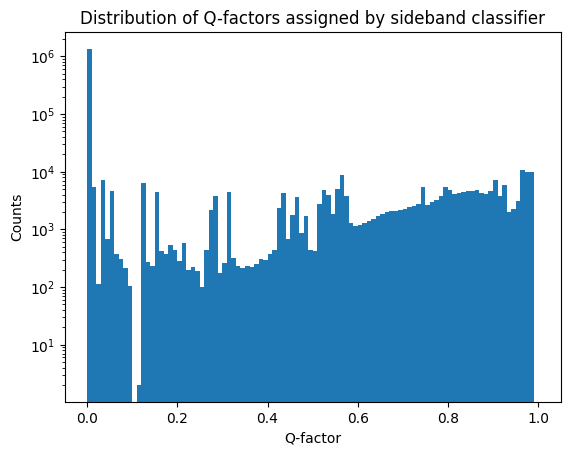

In [11]:
plt.figure()
plt.hist(Q, bins=100, range=(0., 1))
plt.yscale("log")
plt.xlabel("Q-factor")
plt.ylabel("Counts")
plt.title("Distribution of Q-factors assigned by sideband classifier")
plt.show()

In [12]:
import matplotlib.pyplot as plt
import numpy as np

def plot_MM_weighted(MM, Q, bins=80, range=(0.65, 1.25)):

    # Unweighted (= total data)
    fig, ax = plt.subplots(1, 2, figsize=(12,10))
    ax[0].hist(MM, bins=bins, range=range, histtype='step', alpha=0.7)

    # Weighted by Q-factors (= estimated signal)
    ax[0].hist(MM, bins=bins, weights=Q, range=range, histtype='step', alpha=0.7, label='Predicted Signal (Q-weighted)')

    # Weighted (1-Q) = background estimate
    ax[0].hist(MM, bins=bins, weights=(1-Q), range=range, histtype='step', alpha=0.7, label='Predicted Background (1-Q)')

    ax[1].hist(MM, bins=bins, range=range, histtype='step', alpha=0.7)

    # Weighted by Q-factors (= estimated signal)
    ax[1].hist(MM[y_train==1], bins=bins, range=range, histtype='step', alpha=0.7, label='True Signal (Q-weighted)')

    # Weighted (1-Q) = background estimate
    ax[1].hist(MM[y_train==0], bins=bins, range=range, histtype='step', alpha=0.7, label='True Background (1-Q)')

    ax[0].set_xlabel("MM [GeV]")
    ax[1].set_xlabel("MM [GeV]")
    ax[0].set_ylabel("Counts")
    ax[1].set_ylabel("Counts")
    ax[0].legend()
    ax[1].legend()
    plt.tight_layout()
    plt.show()

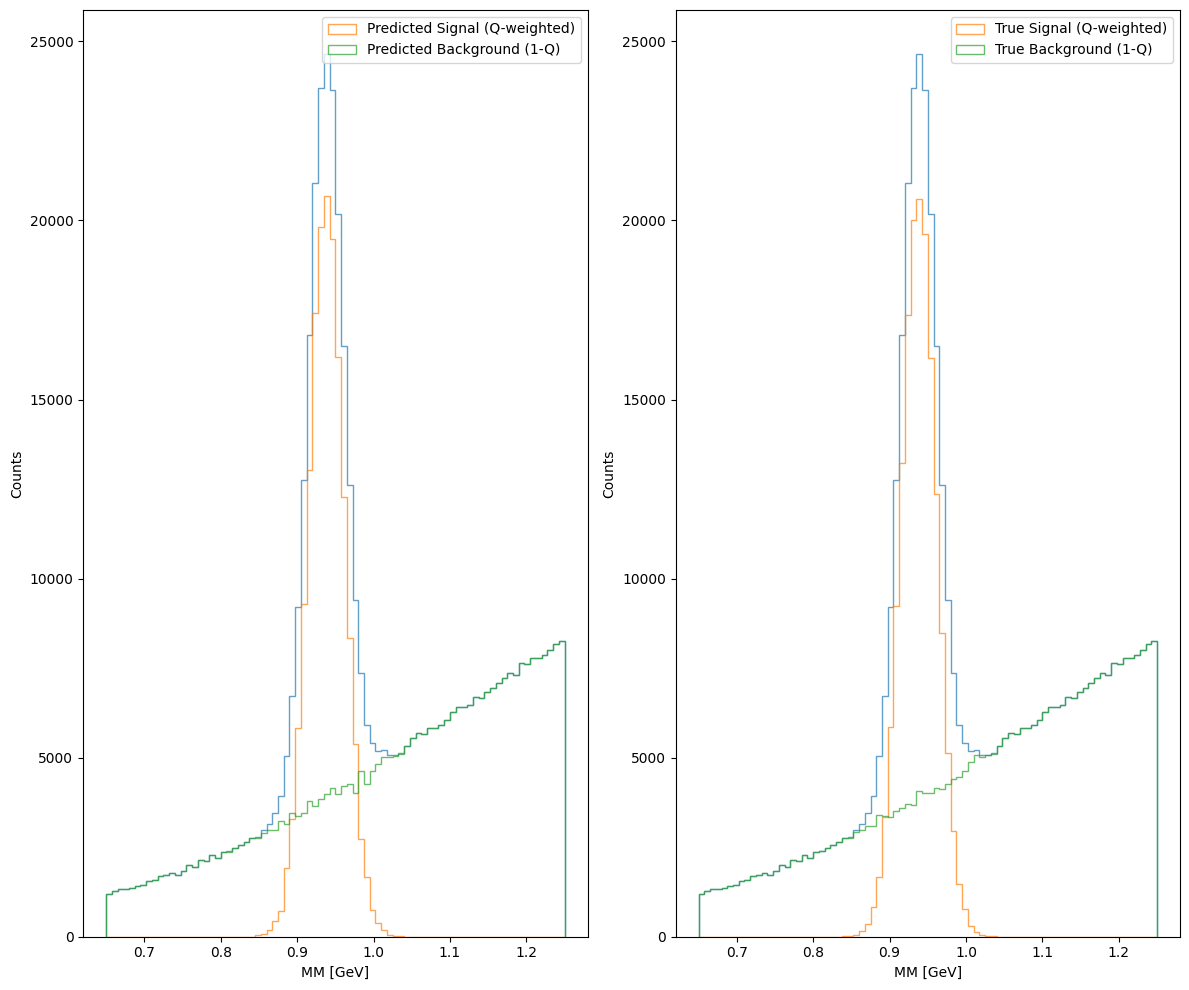

In [14]:
# %matplotlib widget
plot_MM_weighted(MM, Q)

In [151]:
import numpy as np

# true counts per MM bin
true_sig_counts, edges = np.histogram(MM[y_train==1], bins=80, range=(0.65, 1.25))

# Q-weighted signal estimate
q_sig_counts, _       = np.histogram(MM,          bins=80, range=(0.65, 1.25), weights=Q)

centers = 0.5*(edges[:-1] + edges[1:])
ratio   = np.divide(q_sig_counts, true_sig_counts, out=np.zeros_like(q_sig_counts, dtype=float),
                    where=true_sig_counts>0)

for i,(c, ts, qs, r) in enumerate(zip(centers, true_sig_counts, q_sig_counts, ratio)):
    print(f"bin {i:2d}, MM={c:.3f}, true={ts:5d}, Q_sum={qs:7.1f}, ratio={r:5.3f}")

bin  0, MM=0.654, true=    0, Q_sum=    0.0, ratio=0.000
bin  1, MM=0.661, true=    0, Q_sum=    0.0, ratio=0.000
bin  2, MM=0.669, true=    0, Q_sum=    0.0, ratio=0.000
bin  3, MM=0.676, true=    0, Q_sum=    0.0, ratio=0.000
bin  4, MM=0.684, true=    0, Q_sum=    0.0, ratio=0.000
bin  5, MM=0.691, true=    0, Q_sum=    0.0, ratio=0.000
bin  6, MM=0.699, true=    0, Q_sum=    0.0, ratio=0.000
bin  7, MM=0.706, true=    0, Q_sum=    0.0, ratio=0.000
bin  8, MM=0.714, true=    0, Q_sum=    0.0, ratio=0.000
bin  9, MM=0.721, true=    0, Q_sum=    0.0, ratio=0.000
bin 10, MM=0.729, true=    0, Q_sum=    0.0, ratio=0.000
bin 11, MM=0.736, true=    0, Q_sum=    0.0, ratio=0.000
bin 12, MM=0.744, true=    0, Q_sum=    0.0, ratio=0.000
bin 13, MM=0.751, true=    0, Q_sum=    0.0, ratio=0.000
bin 14, MM=0.759, true=    0, Q_sum=    0.0, ratio=0.000
bin 15, MM=0.766, true=    0, Q_sum=    0.0, ratio=0.000
bin 16, MM=0.774, true=    0, Q_sum=    0.0, ratio=0.000
bin 17, MM=0.781, true=    0, Q

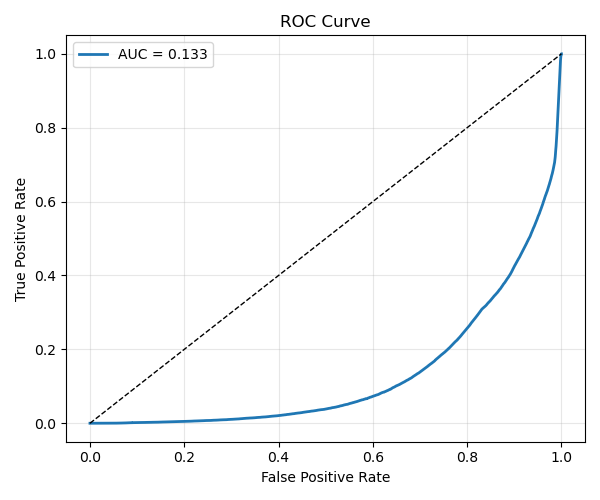

AUC = 0.1327965951678234


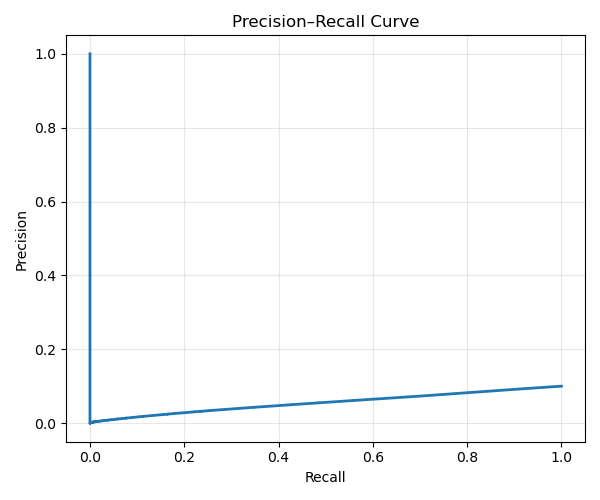

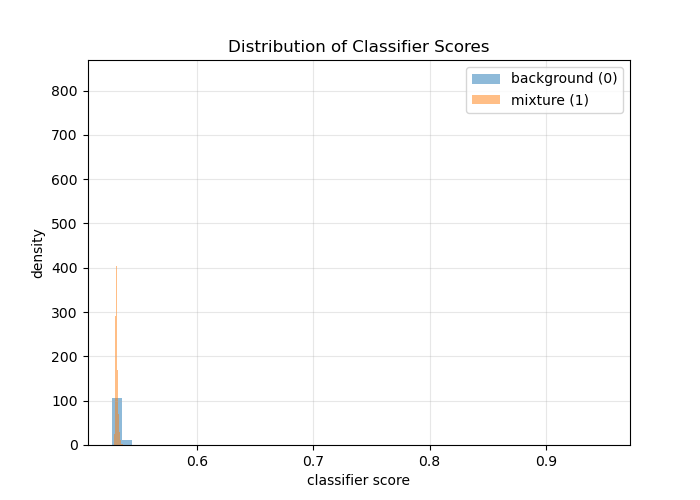

0.5287222


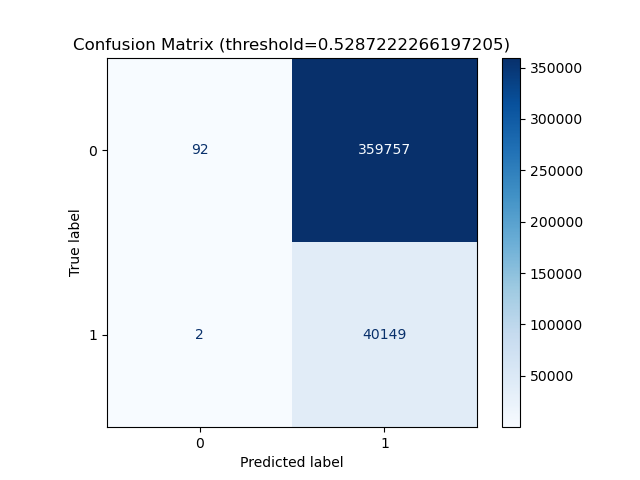

In [207]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    roc_curve, auc,
    precision_recall_curve,
    confusion_matrix,
    ConfusionMatrixDisplay
)

def plot_PR(y_true, y_score):
    precision, recall, _ = precision_recall_curve(y_true, y_score)

    plt.figure(figsize=(6,5))
    plt.plot(recall, precision, lw=2)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision–Recall Curve")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

def plot_ROC(y_true, y_score):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6,5))
    plt.plot(fpr, tpr, lw=2, label=f"AUC = {roc_auc:.3f}")
    plt.plot([0,1], [0,1], 'k--', lw=1)

    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    return roc_auc


def plot_confusion(y_true, y_score, threshold=0.5):
    y_pred = (y_score >= threshold).astype(int)
    
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(cm)
    
    disp.plot(cmap="Blues", values_format="d")
    plt.title(f"Confusion Matrix (threshold={threshold})")
    plt.show()


def plot_score_distributions(y_true, y_score, bins=50):
    plt.figure(figsize=(7,5))

    plt.hist(y_score[y_true==0], bins=bins, alpha=0.5, label="background (0)", density=True)
    plt.hist(y_score[y_true==1], bins=bins, alpha=0.5, label="mixture (1)", density=True)

    plt.xlabel("classifier score")
    plt.ylabel("density")
    plt.title("Distribution of Classifier Scores")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

# Evaluate on validation region
raw_scores = model.predict(X_test[:,1:], verbose=0).flatten()

# True labels: 0=sideband, 1=mixture
y_true_val = y_test

# ROC / AUC
auc_val = plot_ROC(y_true_val, raw_scores)
print("AUC =", auc_val)

# PR Curve
plot_PR(y_true_val, raw_scores)

# Score distributions
plot_score_distributions(y_true_val, raw_scores)

# Confusion matrix
fpr, tpr, thr = roc_curve(y_true_val, raw_scores)
j = tpr - fpr
best_thr = thr[np.argmax(j)]
print(best_thr)

plot_confusion(y_true_val, raw_scores, threshold=best_thr)

In [155]:
import numpy as np
from sklearn.model_selection import train_test_split

# ----------------------------------------------------
# New correlated toy generator
# Columns: [MM, p_mag, Q2, W, costheta]
# ----------------------------------------------------

def _sample_costheta_signal(rs, n, a=1.5):
    """
    Forward-peaked cos(theta) for signal: p(z) ∝ (1 + a z)^2 on [-1,1].
    """
    m = 5 * n
    z = rs.uniform(-1.0, 1.0, size=m)
    w = (1.0 + a * z) ** 2
    w /= w.max()
    u = rs.uniform(0.0, 1.0, size=m)
    keep = u < w
    out = z[keep][:n]
    if out.size < n:  # in rare case, pad
        out = np.pad(out, (0, n - out.size), mode="edge")
    return np.clip(out, -1.0, 1.0)


def generate_correlated_toy(num_events=200_000,
                            signal_fraction=0.4,
                            rng=42):
    """
    Returns:
        X_train, X_test, y_train, y_test
    Columns of X: [MM, p_mag, Q2, W, costheta]
    y: 1 = signal, 0 = background
    """
    rs = np.random.default_rng(rng)
    n_sig = int(num_events * signal_fraction)
    n_bkg = num_events - n_sig

    # ---------- Q2 distributions ----------
    # Signal: harder Q2, narrower
    Q2_sig = rs.gamma(shape=3.0, scale=0.7, size=n_sig) + 0.6
    # Background: softer Q2, broader
    Q2_bkg = rs.gamma(shape=1.5, scale=1.3, size=n_bkg) + 0.2

    # ---------- cos(theta) ----------
    # Signal: strongly forward
    ct_sig = _sample_costheta_signal(rs, n_sig, a=1.8)
    # Background: broad, slight backward preference
    ct_bkg = np.clip(rs.normal(loc=-0.2, scale=0.6, size=n_bkg), -1.0, 1.0)

    # ---------- W correlated with Q2 ----------
    # Signal: tighter relation, less noise
    W_sig = 2.10 + 0.22 * np.tanh(Q2_sig / 2.0) + rs.normal(0.0, 0.03, size=n_sig)
    # Background: different slope + more noise
    W_bkg = 2.00 + 0.10 * np.sqrt(Q2_bkg) + rs.normal(0.0, 0.08, size=n_bkg)

    # ---------- p_mag correlated with W and cos(theta) ----------
    # Signal: narrow band tied to W and ct
    p_sig = 1.4 * (W_sig - 2.0) * (1.0 - 0.35 * ct_sig) + rs.normal(0.0, 0.04, size=n_sig)
    # Background: broader, weaker dependence
    p_bkg = 1.0 * (W_bkg - 2.0) * (1.0 - 0.10 * ct_bkg) + rs.normal(0.0, 0.25, size=n_bkg)
    p_sig = np.clip(p_sig, 0.0, None)
    p_bkg = np.clip(p_bkg, 0.0, None)

    # ---------- Missing mass MM ----------
    # Signal: narrow peak near nucleon mass, resolution grows with Q2
    mu_sig = 0.938
    sigma0 = 0.010
    sigma_q2 = 0.004
    MM_sig = rs.normal(mu_sig, sigma0 + sigma_q2 * np.sqrt(Q2_sig))
    MM_sig = np.clip(MM_sig, 0.70, 1.20)

    # Background: smooth shape, rising toward high MM, no peak
    u = rs.uniform(0.0, 1.0, size=n_bkg)
    MM_bkg = 0.65 + (1.25 - 0.65) * (u ** 0.7)  # tilt upward in MM
    MM_bkg += rs.normal(0.0, 0.015, size=n_bkg)
    MM_bkg = np.clip(MM_bkg, 0.65, 1.25)

    # ---------- Stack & shuffle ----------
    X_sig = np.column_stack([MM_sig, p_sig, Q2_sig, W_sig, ct_sig])
    X_bkg = np.column_stack([MM_bkg, p_bkg, Q2_bkg, W_bkg, ct_bkg])

    X = np.vstack([X_sig, X_bkg])
    y = np.concatenate([
        np.ones(n_sig, dtype=int),
        np.zeros(n_bkg, dtype=int)
    ])

    idx = rs.permutation(len(y))
    X = X[idx]
    y = y[idx]

    return train_test_split(X, y, test_size=0.2, random_state=rng)

In [191]:
X_train, X_test, y_train, y_test = generate_correlated_toy()
from tensorflow import keras

model = keras.Sequential([
    keras.layers.Input(shape=(X_train.shape[1],)),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=5, batch_size=4096, verbose=1)

scores = model.predict(X_test, verbose=0).ravel()

from sklearn.metrics import roc_auc_score
print("AUC (true labels):", roc_auc_score(y_test, scores))

Epoch 1/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7768 - loss: 0.5011
Epoch 2/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7768 - loss: 0.5011
Epoch 2/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8647 - loss: 0.3354
Epoch 3/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8647 - loss: 0.3354
Epoch 3/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8849 - loss: 0.2984
Epoch 4/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8849 - loss: 0.2984
Epoch 4/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8940 - loss: 0.2760
Epoch 5/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8940 - loss: 0.2760
Epoch 5/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9024 - loss: 0.2539
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9024 - loss: 0.2539
AUC (true labels): 0.9626443387915419
AUC (true labels): 0.9626443387915419


In [208]:
def predict_on_test(model, X_test, y_test, bin_edges, pi_s, T=None):
    """
    Predict classifier scores and Q-values on the test dataset.

    Inputs:
        model     : trained sideband classifier
        X_test    : test features (MM, p, Q2, W, ct)
        y_test    : true labels (1 = signal, 0 = background)
        bin_edges : same MM binning used in training
        pi_s      : signal fraction per bin (from training or MC truth)
        T         : temperature (for soft Q); if None, skip soft Q

    Returns:
        scores_test : raw classifier scores
        Q_test      : ranked (hard) Q values
        Q_soft      : soft temperature-scaled Q values (or None)
        bin_id_test : MM bin IDs
    """

    # -----------------------------------------------
    # 1. Extract non-MM features (what the model uses)
    # -----------------------------------------------
    X_test_features = X_test[:, 1:]   # remove MM
    MM_test = X_test[:, 0]

    # -----------------------------------------------
    # 2. Predict classifier scores
    # -----------------------------------------------
    scores_test = model.predict(X_test_features, batch_size=5000, verbose=0).flatten()

    # -----------------------------------------------
    # 3. Compute MM-bin IDs
    # -----------------------------------------------
    bin_id_test = np.digitize(MM_test, bin_edges) - 1
    num_bins = len(bin_edges) - 1

    # -----------------------------------------------
    # 4. Ranked Q assignment
    # -----------------------------------------------
    Q_test = compute_ranked_Q(scores_test, bin_id_test, pi_s, num_bins)

    # -----------------------------------------------
    # 5. Optional: Soft / temperature-scaled Q
    # -----------------------------------------------
    Q_soft = None
    if T is not None:
        logit = np.log(scores_test / (1 - scores_test + 1e-9))
        Q_soft = 1.0 / (1.0 + np.exp(-logit / T))

    return scores_test, Q_test, Q_soft, bin_id_test

In [213]:
scores_test, Q_test, Q_soft, bin_id_test = predict_on_test(
    model=model,
    X_test=X_test,
    y_test=y_test,
    bin_edges=bin_edges,
    pi_s=pi_s,
    T=4      # optional: soft Q; set None for no soft Q
)

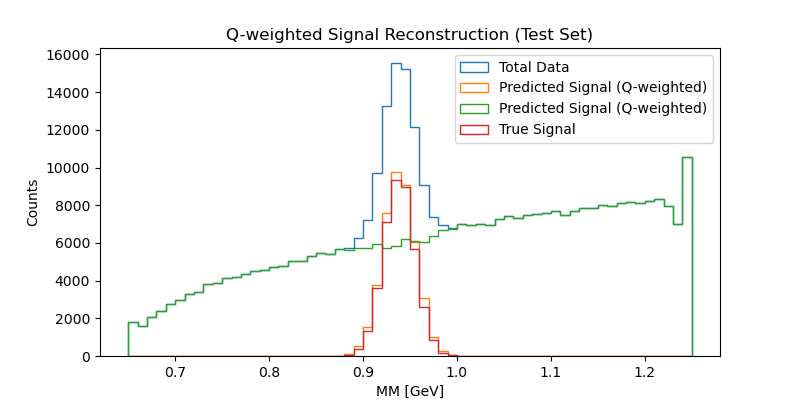

In [214]:
plt.figure(figsize=(8,4))

# Total (unweighted)
plt.hist(X_test[:,0], bins=60, range=(0.65,1.25), histtype='step', label='Total Data')

# Q-weighted signal estimate
plt.hist(X_test[:,0], bins=60, range=(0.65,1.25),
         weights=Q_test, histtype='step', label='Predicted Signal (Q-weighted)')

plt.hist(X_test[:,0], bins=60, range=(0.65,1.25),
         weights=1-Q_test, histtype='step', label='Predicted Signal (Q-weighted)')

# True signal (from labels)
plt.hist(X_test[y_test==1,0], bins=60, range=(0.65,1.25),
         histtype='step', label='True Signal')

plt.legend()
plt.xlabel("MM [GeV]")
plt.ylabel("Counts")
plt.title("Q-weighted Signal Reconstruction (Test Set)")
plt.show()

In [183]:
import numpy as np

# true counts per MM bin
true_sig_counts, edges = np.histogram(X_test[:,0][y_test==1], bins=80, range=(0.65, 1.25))

# Q-weighted signal estimate
q_sig_counts, _       = np.histogram(X_test[:,0],          bins=80, range=(0.65, 1.25), weights=Q_test)

centers = 0.5*(edges[:-1] + edges[1:])
ratio   = np.divide(q_sig_counts, true_sig_counts, out=np.zeros_like(q_sig_counts, dtype=float),
                    where=true_sig_counts>0)

for i,(c, ts, qs, r) in enumerate(zip(centers, true_sig_counts, q_sig_counts, ratio)):
    print(f"bin {i:2d}, MM={c:.3f}, true={ts:5d}, Q_sum={qs:7.1f}, ratio={r:5.3f}")

bin  0, MM=0.654, true=    0, Q_sum=    0.0, ratio=0.000
bin  1, MM=0.661, true=    0, Q_sum=    0.0, ratio=0.000
bin  2, MM=0.669, true=    0, Q_sum=    0.0, ratio=0.000
bin  3, MM=0.676, true=    0, Q_sum=    0.0, ratio=0.000
bin  4, MM=0.684, true=    0, Q_sum=    0.0, ratio=0.000
bin  5, MM=0.691, true=    0, Q_sum=    0.0, ratio=0.000
bin  6, MM=0.699, true=    0, Q_sum=    0.0, ratio=0.000
bin  7, MM=0.706, true=    0, Q_sum=    0.0, ratio=0.000
bin  8, MM=0.714, true=    0, Q_sum=    0.0, ratio=0.000
bin  9, MM=0.721, true=    0, Q_sum=    0.0, ratio=0.000
bin 10, MM=0.729, true=    0, Q_sum=    0.0, ratio=0.000
bin 11, MM=0.736, true=    0, Q_sum=    0.0, ratio=0.000
bin 12, MM=0.744, true=    0, Q_sum=    0.0, ratio=0.000
bin 13, MM=0.751, true=    0, Q_sum=    0.0, ratio=0.000
bin 14, MM=0.759, true=    0, Q_sum=    0.0, ratio=0.000
bin 15, MM=0.766, true=    0, Q_sum=    0.0, ratio=0.000
bin 16, MM=0.774, true=    0, Q_sum=    0.0, ratio=0.000
bin 17, MM=0.781, true=    0, Q

In [211]:
def check_yields(MM, y_true, scores, bin_edges, pi_s):
    bin_id = np.digitize(MM, bin_edges) - 1
    num_bins = len(bin_edges) - 1

    Q_ranked = compute_ranked_Q(scores, bin_id, pi_s, num_bins)

    Y_true   = y_true.sum()
    Y_Q      = Q_ranked.sum()

    print(f"True signal yield       : {Y_true:.1f}")
    print(f"Ranked-Q signal yield   : {Y_Q:.1f}")
    print(f"Relative bias (ranked-Q): {(Y_Q - Y_true)/Y_true:.3%}")

    return Q_ranked

In [215]:
check_yields(X_test[:,0], y_test, scores_test, bin_edges, pi_s)

True signal yield       : 40151.0
Ranked-Q signal yield   : 42764.4
Relative bias (ranked-Q): 6.509%


array([0.        , 0.        , 0.        , ..., 0.02713492, 0.13806662,
       0.        ])

In [186]:
def compare_bin_fractions_test(MM_test, y_test, bin_edges, pi_s):
    bin_id_test = np.digitize(MM_test, bin_edges) - 1
    num_bins = len(bin_edges)-1

    print(f"{'bin':>3}  {'pi_s(train)':>10}  {'frac(test)':>12}   {'N_test':>7}")
    print("-"*40)
    for b in range(num_bins):
        mask = bin_id_test == b
        if not np.any(mask):
            continue
        frac_test = y_test[mask].mean()
        print(f"{b:3d}  {pi_s[b]:10.4f}  {frac_test:12.4f}   {mask.sum():7d}")

compare_bin_fractions_test(X_test[:,0], y_test, bin_edges, pi_s)

bin  pi_s(train)    frac(test)    N_test
----------------------------------------
  0      0.0000        0.0000      2140
  1      0.0000        0.0000      2127
  2      0.0000        0.0000      2839
  3      0.0000        0.0000      3250
  4      0.0000        0.0000      3671
  5      0.0000        0.0000      4043
  6      0.0000        0.0000      4358
  7      0.0000        0.0000      4744
  8      0.0000        0.0000      5023
  9      0.0000        0.0000      5179
 10      0.0000        0.0000      5408
 11      0.0000        0.0000      5577
 12      0.0000        0.0000      5746
 13      0.0000        0.0000      5834
 14      0.0000        0.0000      6199
 15      0.0000        0.0000      6279
 16      0.0000        0.0000      6667
 17      0.0003        0.0003      6665
 18      0.0024        0.0036      6938
 19      0.0235        0.0252      7228
 20      0.1243        0.1289      8279
 21      0.3430        0.3413     11250
 22      0.5380        0.5422     1648